# Exploring Sonoma County animal shelter intake and outcome data 
## Data source
For this data analysis, we are using the Sonoma County Animal Shelter Intake and Outcome dataset collected and made publicly available by Sonoma County with the purpose of helping the community better understand the animals being cared for by the shelter.

The dataset includes each animal’s name, type, breed, color, sex, size, date of birth, kennel/impound details and ID, intake/outcome date, days in shelter, intake/outcome types, health condition, and outcome location. The data spans from August 2013 to May 2023.
## Questions we seek to answer
- What types of animals are cared for by the shelter?
- How many animals come into/leave the shelter each month?
- Has the number of intakes increased or decreased over time?
- During which month does the shelter have the most intakes?
- What are the most common outcomes?
- Is gender a factor in how long an animal stays at the shelter?
- Is age a factor in how long an animal stays at the shelter?
- Has the adoption rate has increased or decreased over time?
- Are we able to predict an animal's outcome based on certain factors?

## Importing needed libraries/modules and reading the data from the CSV

To begin, we import the packages we will be using to hold/manipulate the data (pandas, numpy), to plot/map/vizualize the data (matplotlib.pyplot, gmplot, IPython.display, seaborn), and to build a prediction model (sklearn). We also import functions we created that are stored in separate .py files. We also import our dataset from an external CSV as a Pandas dataframe. 

In [25]:
# Importing needed libraries/modules
from pandas import read_csv, to_datetime, Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import gmplot
from IPython.display import IFrame
from project_functions import monthly_in_out, convertAgeToYears, requestIntakeDateYearInput, type_pie_chart, requestOutcomeDateYearInput, forecast_2023
from seaborn import scatterplot
from configAPI import APIkey
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from scipy import stats

# Open data file
df = read_csv('intake_and_outcome_data.csv')

## Cleaning up/converting data
### Converting the name; birth, intake, and outcome date; and outcome type columns

After importing the CSV file as a Pandas dataframe, we clean up some of the data---replacing blanks in the Name column to "No name", converting all dates to a datetime object, replacing blanks in the Outcome Type column to Pending, and removing any duplicate categories in the Intake Type and Outcome Type columns---using .fillna(), .replace(), and .mask().

In [26]:
# Replacing all NaN values of name column with "No name"
df["Name"].fillna("No name", inplace=True)

# Converts string dates to datetime dtypes
df["Date Of Birth"] = to_datetime(df["Date Of Birth"])
df["Intake Date"] = to_datetime(df["Intake Date"])
df["Outcome Date"] = to_datetime(df["Outcome Date"])

# Replacing all NaN values of outcome type column with "Pending"
df["Outcome Type"].fillna("Pending", inplace=True)

# Remove any duplicate categories
# Replacing all RTOS values of outcome type column with "RETURN TO OWNER"
df["Outcome Type"].replace("RTOS", "RETURN TO OWNER", inplace=True)
# Replacing all OS APPT values of intake type column with "OWNER SURRENDER"
df["Intake Type"].mask(df["Intake Type"] == "OS APPT", "OWNER SURRENDER", inplace=True)

### Calculating age and adding Age In Days and Age Group columns

After converting the columns for the animals' dates of birth and intake dates, we then calculate the age of each animal (if DOB is provided) and add an Age In Days column to the dataframe. We then use the Age in Days column to bucket the animals by age group. If they are a year or less old, they are categorized as Young; between a year and ten years old, Adult; and over ten years old, Senior.

We also separate out a new column (Fixed) that tells us whether or not the animal has been spayed or neutered. 

In [27]:
# Find age in days of animal on intake date if birth date provided
birth_dates = np.array(df["Date Of Birth"], dtype='datetime64[D]')
intake_dates = np.array(df["Intake Date"], dtype='datetime64[D]')
ages = np.array((intake_dates - birth_dates), dtype="int")
ages = np.where(ages < 0, 0, ages) # changes age to zero if born after intake
ages = np.where(np.isnat(birth_dates), np.nan, ages) # gives NaN value if no birthday provided and changes dtype to float64
df['Age In Days'] = ages

# Creating age groups
df["Age Group"] = ages.astype("str")
df["Age Group"].mask(df["Age In Days"] < 366, "Young", inplace=True)
df["Age Group"].mask(df["Age In Days"] > 365, "Adult", inplace=True)
df["Age Group"].mask(df["Age In Days"] > 3650, "Senior", inplace=True)
df["Age Group"].mask(df["Age Group"] == 'nan', "Unknown", inplace=True)

# Separating sex and spay/neuter status
# If sex is listed (rather than Neutered or Spayed), it is assumed that the animal is not spayed/neutered.
df["Fixed"] = df["Sex"]
df["Fixed"].mask(df["Fixed"] == "Female", "Unaltered", inplace=True)
df["Fixed"].mask(df["Fixed"] == "Male", "Unaltered", inplace=True)

## Preview the data
Below you can preview the data with blanks filled in and the new columns added. 

In [28]:
# Preview 
df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Zip Codes,Age In Days,Age Group,Fixed
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,2009-10-29,K22-043412,TRUCK,A396382,2022-12-26,2022-12-26,0,STRAY,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1,26077.0,4806.0,Senior,Neutered
1,No name,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaT,K23-044095,TRUCK,A416206,2023-03-15,2023-03-15,0,STRAY,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1,NaN,NaN,Unknown,Unknown
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,2020-03-10,K23-044090,DS80,A399488,2023-03-15,2023-03-15,0,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1,31039.0,1100.0,Adult,Neutered
3,No name,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,2011-06-26,K22-043405,VET,A414520,2022-12-23,2022-12-27,4,STRAY,FIELD,DISPOSAL,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1,26076.0,4198.0,Senior,Spayed
4,PUDGY,DOG,CHIHUAHUA SH/SCHIPPERKE,TAN,Neutered,MED,2013-07-20,K23-043813,DA27,A415428,2023-02-08,2023-03-15,35,OWNER SURRENDER,OVER THE COUNTER,TRANSFER,MUTTVILLE,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,94103.0,"94103(37.77672, -122.40779)",1,28853.0,3490.0,Adult,Neutered


## Animal types
To begin our analysis, we wanted to know what the most common types of animals that entered the shelter. We used .value_counts() to get a count of each type of animal listed in the Type column of the dataframe. We then created a pie chart using plt.pie plot the percentages of each type. Dogs are the most common type of animal being cared for at the shelter, comprising 56.26% of all animal intakes, followed by cats (35.31%). 

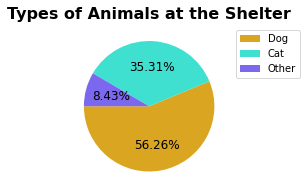

In [29]:
animal_types = df["Type"].value_counts()
type_pie_chart(animal_types, "Types of Animals at the Shelter")

## Animal intakes
### Animal intakes per month
To better see the intake data for each year, we plot monthly intakes for the years included in the data set (2013-2023) based on user input. To do this, we create a pandas dataframe based on the inputted year and use dt.month.value_counts() to get a count of each month in the dataframe. We then plot this information on a bar graph.

Enter a year between 2013 and 2023 to view number of intakes per month:  2020


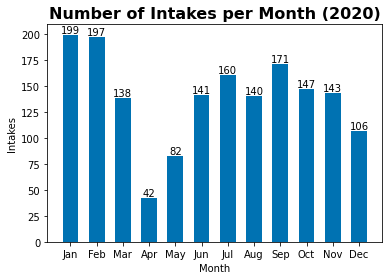

Total intakes for 2020: 1,666


In [30]:
# Find number of intakes by month for specific year
year = requestIntakeDateYearInput()
df_in_date = df[df["Intake Date"].dt.strftime("%Y") == f"{year}"]
total_annual_intakes = len(df_in_date.index)
monthly_intakes = Series.sort_index(df_in_date["Intake Date"].
                                    dt.month.value_counts())

# Plot monthly intakes
monthly_in_out(monthly_intakes, year, "Intakes")
print(f"Total intakes for {year}: {total_annual_intakes:,}")

### Average animal intakes per month
We also wanted to find out how many intakes the shelter has on average for each month of the year. We use dt.month.value_counts() to get a count of the total number of intakes for each month for all years. To find the average of each month, we divide the total intakes for each month by the number of years in the dataset.

Based on monthly averages, we see that the shelter receives the most intakes during the summer months. 

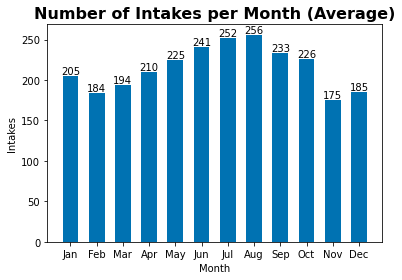

In [31]:
# Find average number of intakes for each month
all_monthly_intakes = (Series.sort_index(df["Intake Date"].dt.month.value_counts())).to_numpy() 
num_of_years = round((df["Intake Date"].max()-df["Intake Date"].min())/np.timedelta64(1, 'Y'), 2)
avg_monthly_intakes = Series((all_monthly_intakes/num_of_years).round(decimals=0), index=[x for x in range(1, 13)])

monthly_in_out(avg_monthly_intakes, "Average", "Intakes")

## Outcomes
### Outcome types
We wanted to know the most common outcomes for animals that entered the shelter. Like for animal types, we used .value_counts() to get a count of each type of outcome listed in the Outcome Type column of the dataframe. We then created a pie chart using plt.pie to plot the percentages of each type. The most common outcome for animals at the shelter is "return to owner" at 33.96%, followed by adoption (29.43%) and transfer (21.10%). Percentage values for disposal, died, and excaped/stolen are not shown since their values are less than 1%. 

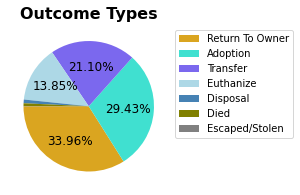

In [32]:
# Plot outcome types
outcomes = df["Outcome Type"].mask(df["Outcome Type"] == "Pending").value_counts()
type_pie_chart(outcomes, "Outcome Types")

### Outcomes per month
As we did with the intake data, we plot monthly outcomes for the years included in the data set (2014-2023, Note: There were no outcomes listed for 2013.) based on user input. To do this, we create a pandas dataframe based on the inputted year and use dt.month.value_counts() to get a count of each month in the dataframe. We then plot this information on a bar graph.

Enter a year between 2014 and 2023 to view number of outcomes per month:  2020


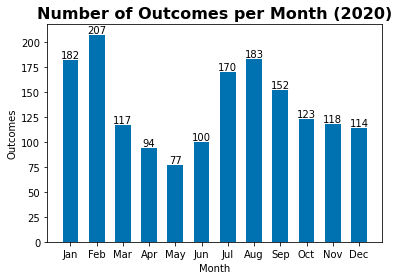

Total outcomes for 2020: 1,637


In [33]:
# Find number of outcomes by month for specific year
year = requestOutcomeDateYearInput("number of outcomes per month")
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]
total_annual_outcomes = len(df_out_date.index)
monthly_outcomes = Series.sort_index(df_out_date["Outcome Date"].
                                     dt.month.value_counts())
# Plot monthly outcomes
monthly_in_out(monthly_outcomes, year, "Outcomes")
print(f"Total outcomes for {year}: {total_annual_outcomes:,}")

## Outcome locations
### Visualizing animal outcome locations in a Google Map based on year

We noticed in the dataset that outcome locations were provided. We decided to map the locations to get a better view of what's happening with regard to the outcome location data. We used gmplot to map the latitude and longitude of each animal for a certain year based on user input. The map tells us that the impact of the animal shelter reaches much further than we anticipated. Some animals' outcome locations were within Sonoma County, while other locations were elsewhere in California or even out of state. This data could be further explored to gain insight on why some animal locations may be outside of Sonoma County. Animals may be transferred out to other rescues or, if they were returned to their owners, perhaps the owners have moved out of the county/state.

In [34]:
#Get user input year
year = requestOutcomeDateYearInput("outcome locations")
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]

#create a default Google Map
gmap=gmplot.GoogleMapPlotter(lat='38.43807',lng='-122.71247', zoom=7)
gmap.apikey = APIkey()

#Iterate through the data set
for index, row in df_out_date.iterrows():
    #Get location data
    location = str(row["Location"])
    #Massage data, only plot locations that have a lat, long
    if '(' in location:
        location = str(row["Location"]).split('(')[1].removesuffix(')')
        latitude = float(location.split(',')[0])
        longitude = float(location.split(',')[1])
        title = row["Name"]
        if title == "No name":
            title = ''
        breed = row["Breed"]
        title = f"Name: {title} - Breed: {breed}"
        gmap.marker(latitude, longitude, title=title)
gmap.draw("map.html")
IFrame(src='map.html', width=700, height=600)

Enter a year between 2014 and 2023 to view outcome locations:  2020


## Length of stay at shelter
We also wanted to see how long on average an animal's length of stay at the shelter is. Length of stay is the amount of time, from the time of the animal's intake to the time of the animal's outcome, an animal is in the shelter. We used numpy to find the mean and median values of the Days in Shelter column and scipy.stats.mode to find the mode of the days in shelter values. Considering the averages below, it seems that Sonoma County manages length of stay for animals fairly well. Animals with longer lengths of stay typically require the allocation of more resources to get them out of the shelter.  

The mean average length of stay for an animal at the shelter is 18.4 days.
The median length of stay for an animal at the shelter is 8.0 days.
The mode for number of days in the shelter is 0. 18.86% of the values in the Days in Shelter column equal zero.
Only 8.28% of animals stayed longer than 50 days.


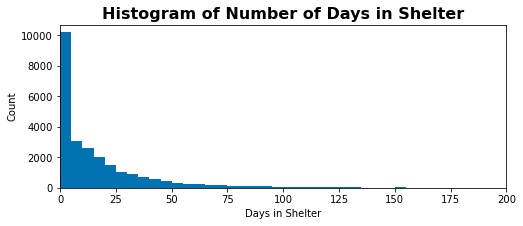

In [67]:
# Calculate the average length of stay
avg_los = np.nanmean(df["Days in Shelter"])
median_los = np.median(df["Days in Shelter"])
mode_los = stats.mode(df['Days in Shelter'], keepdims=True)
print(f"The mean average length of stay for an animal at the shelter is {avg_los:.3} days.")
print(f"The median length of stay for an animal at the shelter is {median_los:.3} days.")
print(f"The mode for number of days in the shelter is {mode_los[0][0]}. {(mode_los[1][0]/len(df['Days in Shelter'])):.2%} of the values in the Days in Shelter column equal zero.") 
print(f"Only {(len(df.loc[df['Days in Shelter'] > 50, 'Days in Shelter'])/len(df['Days in Shelter'])):.2%} of animals stayed longer than 50 days.")

# Plotting distribution of days in shelter to a historgram
plt.figure(figsize=(8,3))
binwidth = 5
plt.title("Histogram of Number of Days in Shelter", size=16, weight="bold")
plt.hist(df["Days in Shelter"], bins=range(min(df["Days in Shelter"]), max(df["Days in Shelter"]) + binwidth, binwidth))
plt.xlabel("Days in Shelter")
plt.xlim(0, 200)
plt.ylabel("Count")
#plt.ylim(0, 3000) # Y axis limit to zoom in 
plt.show()

### Gender and length of stay
We wanted to see if there was any correlation between gender and length of stay at shelter. Based on the plot below, gender did not seem to affect how long the animal stayed at the shelter. Most animals left the shelter between 0 and 50 days, regardless of gender. 

Female average days in shelter: 11.997448256308477
Male average days in shelter: 11.865361942937986
Neutered average days in shelter: 23.302294845608554
Spayed average days in shelter: 24.19804721655494
Unknown average days in shelter: 5.058691756272402


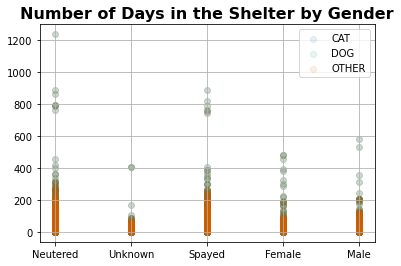

In [76]:
#Get average days in shelter based on gender
for gender in np.unique(df["Sex"]):
    avgGenderDiS = np.average(np.array(df.loc[df["Sex"] == gender,"Days in Shelter"], dtype="float"))
    print(f"{gender} average days in shelter: {avgGenderDiS}")

#Plot days in shelter by gender, each color denotes the type of animal
fig, ax = plt.subplots()
ax.set_title("Number of Days in the Shelter by Gender", size=16, weight="bold")
plt.legend(np.unique(df["Type"]))
for type in np.unique(df["Type"]):
    ax.scatter(x=df["Sex"],y=df["Days in Shelter"], label=type, alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

### Age and length of stay for adopted animals
After finding the average length of stay of all animals, we decided to find the average length of stay for only adopted animals (using numpy), which was longer than the length of stay for an animal regardless of outcome. Knowing the average stay was longer for an adopted animal, we asked: Does the age of the animal influence how long they stay at the shelter before being adopted?

Based on the below scatterplot (created using seaborn), we found that the older the animal is doesn't necessarily affect the duration of their stay at the shelter.

The average age of an animal upon entering the shelter is 3.4 years.
The average age of an animal that gets adopted is 1.8 years.
The average length of stay for an animal that gets adopted is 33.8 days, versus 18.4 days, the average length of stay for an animal regardless of outcome.


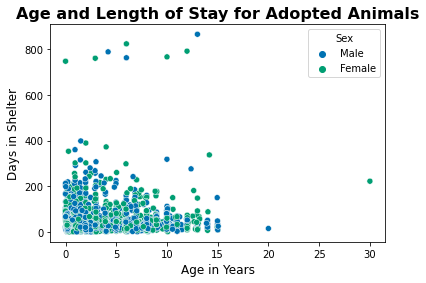

In [69]:
avg_age_in_years = np.nanmean(convertAgeToYears(df["Age In Days"]))
avg_age_of_adopted = np.nanmean(convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")))
avg_los_adopted = np.nanmean(df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"))
print(f"The average age of an animal upon entering the shelter is {avg_age_in_years:.2} years.")
print(f"The average age of an animal that gets adopted is {avg_age_of_adopted:.2} years.")
print(f"The average length of stay for an animal that gets adopted is {avg_los_adopted:.3} days, versus {avg_los:.3} days, the average length of stay for an animal regardless of outcome.")

genders = df["Sex"].mask(df["Sex"] == "Neutered", "Male", inplace=False)
genders = genders.mask(genders == "Spayed", "Female", inplace=False)
plt.figure(figsize=(6, 4))
plt.title("Age and Length of Stay for Adopted Animals", size=16, weight="bold")
plt.ylabel("Days in Shelter", size=12)
plt.xlabel("Age in Years", size=12)
scatterplot(x=convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")), y=df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"), 
            hue=genders.where(genders != "Unknown"))
plt.show()


## Adoptions
### Animal adoption rate
We wondered if the animal adoption rate had increased or decreased since 2013. Based on the below plot, we found that the adoption rate has decreased overtime, with a significant drop in 2020. Leading us to ask why that could be and if intakes also have dropped. 
Note that values for 2023 were forecasted using a three-month moving average.

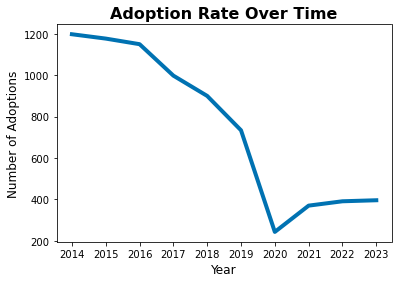

In [70]:
adoptions = df[["Outcome Date", "Outcome Type"]].mask(df["Outcome Type"] != "ADOPTION", inplace=False)
# Find adoption counts
yearly_adoptions =  Series.sort_index(adoptions["Outcome Date"].dt.year.value_counts())

# Forecast adoptions for 2023
df_adoptions_2023 = adoptions[adoptions["Outcome Date"].dt.strftime("%Y") == f"2023"]
monthly_adoptions_2023 = list(Series.sort_index(df_adoptions_2023["Outcome Date"].
                                         dt.month.value_counts().astype('int64')))
yearly_adoptions.update(Series([forecast_2023(monthly_adoptions_2023)], index=[2023]))

plt.figure(figsize=(6, 4))
plt.plot(yearly_adoptions, linewidth=4)
plt.title("Adoption Rate Over Time", size=16, weight="bold")
plt.xticks(yearly_adoptions.index.values)
plt.ylabel("Number of Adoptions", size=12)
plt.xlabel("Year", size=12)
plt.show()

### Animal adoptions versus intakes and all outcomes
We plotted the intakes along with the adoptions to see if the intakes also dropped. The dip in 2020 for intakes, outcomes, and adoptions is more than likely due to COVID-related closures. Decrease over time for intakes could be from an increase in the number of local rescues in the area that are not tracked by Sonoma County or other factors. It would be interesting to see how the intake/adoption rate compares to other shelters in the Bay Area.

Note that values for 2023 having forecasted using a three-month moving average.

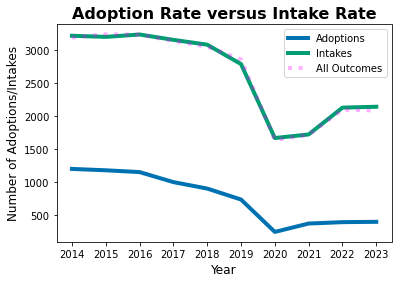

In [71]:
# Plot intakes/adoptions over time 
# Find intake counts
yearly_intakes = Series.sort_index(df["Intake Date"].dt.year.value_counts())
# Forecast intakes for 2023
df_in_date_2023 = df[df["Intake Date"].dt.strftime("%Y") == f"2023"]
monthly_intakes_2023 = list(Series.sort_index(df_in_date_2023["Intake Date"].
                                         dt.month.value_counts().astype('int64')))
yearly_intakes.update(Series([forecast_2023(monthly_intakes_2023)], index=[2023]))

# Find outcome counts
yearly_outcomes = Series.sort_index(df["Outcome Date"].dt.year.value_counts())
# Forecast outcomes for 2023
df_out_date_2023 = df[df["Outcome Date"].dt.strftime("%Y") == f"2023"]
monthly_outcomes_2023 = list(Series.sort_index(df_out_date_2023["Outcome Date"].
                                         dt.month.value_counts().astype('int64')))
yearly_outcomes.update(Series([forecast_2023(monthly_outcomes_2023)], index=[2023]))

# Plot
plt.figure(figsize=(6, 4))
plt.plot(yearly_adoptions, label="Adoptions", linewidth=4)
plt.plot(yearly_intakes[1:], label="Intakes", linewidth=4)
plt.plot(yearly_outcomes, label="All Outcomes", alpha=0.3, color="magenta", linestyle=":", linewidth=4)
plt.xticks(yearly_adoptions.index.values)
plt.title("Adoption Rate versus Intake Rate", size=16, weight="bold")
plt.ylabel("Number of Adoptions/Intakes", size=12)
plt.xlabel("Year", size=12)
plt.legend()
plt.show()

## Predicting outcomes

Since most of the data in this dataset is categorical (strings), we decided to create a Naive Bayes classification model to predict if an animal will have a positive (returned to owner, adopted, tranferred) or negative (euthanized, disposal, died in care, escaped/stolen) outcome. 

We started by pulling out a separate dataframe of predictor variables: Type, Size, Sex, Fixed, Age Group, Intake Type, Intake Condition, Outcome Type.
We then masked the Outcome Type column to hold only two values: Positive, Negative.
And, we masked the Sex column to hold only two values: Male, Female.

In [72]:
outcome_df = DataFrame(df[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition", "Outcome Type"]]).dropna()

# Update gender column to be male or female
outcome_df["Sex"].mask(df["Sex"] == "Neutered", "Male", inplace=True)
outcome_df["Sex"].mask(df["Sex"] == "Spayed", "Female", inplace=True)

# Update outcome type column to be either positive or negative
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "RETURN TO OWNER", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "ADOPTION", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "TRANSFER", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] != "Positive", "Negative", inplace=True)

# Preview data
outcome_df.head()

,Type,Size,Sex,Fixed,Age Group,Intake Type,Intake Condition,Outcome Type
0,DOG,SMALL,Male,Neutered,Senior,STRAY,UNKNOWN,Positive
1,OTHER,SMALL,Unknown,Unknown,Unknown,STRAY,UNKNOWN,Negative
2,DOG,MED,Male,Neutered,Adult,STRAY,UNKNOWN,Positive
3,CAT,SMALL,Female,Spayed,Senior,STRAY,UNKNOWN,Negative
4,DOG,MED,Male,Neutered,Adult,OWNER SURRENDER,UNKNOWN,Positive


### Interger-encoding
sklearn.preprocessing.LabelEncoder() was used to integer-encoded the data values, which were encoded based on alphabetical order.
For reference, we also created a dictionary that maps the category/feature to its integer.

In [73]:
# Create instance of the label encoder
label_encoder = LabelEncoder()
feature_dict = {}
# Loop through dataframe headings to encode each feature variable as an integer within a category
for category in outcome_df.columns:
    sub_cat = outcome_df[category].unique()
    outcome_df[category] = label_encoder.fit_transform(outcome_df[category])
    encoded = outcome_df[category].unique()
    sub_dict = dict(zip(sub_cat, encoded))
    feature_dict[category] = sub_dict

# Preview encoded data
outcome_df.head()

,Type,Size,Sex,Fixed,Age Group,Intake Type,Intake Condition,Outcome Type
0,1,4,1,0,1,5,3,1
1,2,4,2,3,2,5,3,0
2,1,2,1,0,0,5,3,1
3,0,4,0,1,1,5,3,0
4,1,2,1,0,0,3,3,1


### Train and test model
We then split the outcome_df dataframe to get a training dataset and a test dataset. After creating an instance of sklearn.naive_bayes.CategoricalNB, we fit the model with our training dataset, outcome_train. We then score the accuracy of the model based on the test dataset. 

In [74]:
# Create training data
outcome_train = DataFrame(outcome_df[:14637])

# Create test data
outcome_test = DataFrame(outcome_df[14637:])

# Create and train model
categories = outcome_train[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition"]]
outcomes = outcome_train["Outcome Type"].values
model = CategoricalNB(alpha=1)
model.fit(categories, outcomes)

# Test model
test_data = outcome_test[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition"]]
predicted_outcomes = model.predict(test_data)
test_df = DataFrame({"Predictions": predicted_outcomes, "Outcomes": outcome_test["Outcome Type"].values})
print(test_df)
test_accuracy = model.score(test_data, outcome_test["Outcome Type"].values)
print(f"Accuracy score for test data: {test_accuracy:.2%}")

       Predictions  Outcomes
0                1         1
1                1         1
2                0         1
3                1         1
4                1         1
...            ...       ...
10508            1         1
10509            1         1
10510            0         0
10511            1         1
10512            0         1

[10513 rows x 2 columns]
Accuracy score for test data: 89.38%


### Using the model
This example presents the probability of a kitten named Socks having a positive/negative outcome based on its features/conditions.

In [75]:
socks = ["CAT", "KITTN", "Female", "Unaltered", "Young", "BORN HERE", "HEALTHY"]
socks_encoded = DataFrame({key: [feature_dict[key][attr]] for (key, attr) in zip(feature_dict.keys(), socks)})
outcome_dict = {0: "Negative", 1: "Positive"}


prediction = model.predict(socks_encoded)
probabilities = model.predict_proba(socks_encoded)
print(f"Predicted outcome: {outcome_dict[prediction[0]]}")
print(f"Outcome probabilites: Negative - {probabilities[0][0]:.2%}, Positive - {probabilities[0][1]:.2%}")

Predicted outcome: Positive
Outcome probabilites: Negative - 6.21%, Positive - 93.79%


## Key takeaways
- Dogs are the most common type of animal being cared for at the shelter, comprising 56.26% of all animal intakes, followed by cats (35.31%). Only 8.43% of animals at the shelter are of an other type.
- Most animals come into the shelter during the summer months. With August having the highest average at 256 intakes.
- The most common outcome for animals at the shelter is return to owner at 33.96%, followed by adoption (29.43%) and transfer (21.10%).
- Gender does not appear to be a primary factor in how long an animal stays at the shelter.
- Age does not appear to be a primary factor in how long an adopted animal stays at the shelter.
- The adoption rate and intake rate have decreased over time.

## Where do we go from here?